In [11]:
import numpy as np # 행렬이나 다차원 배열을 쉽게 처리할 수있도록 하는 파이썬 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 그래프또는 이미지로 표현 할 수 있게 하는 라이브러리
import keras # 파이썬으로 작성된 오픈소스 신경망 라리브러리, 학습을 위한 함수
from keras import layers 
from keras.models import Model # 딥러닝에서 레이어 기준으로 모델 작성 keras는 입력층,은닉층,출력층으로 된 모델
from sklearn.utils import shuffle # 입력된 1개 이상의 배열을 동일한 순서로 섞는 함수
from sklearn.model_selection import train_test_split # 데이터 분할을 위한 함수
from imgaug import augmenters as iaa # 이미지를 임의적으로 늘려주는 패키지(ex.노이즈,자르거나,붙이거나)

import random # 난수를 만드는 함수


# 로드 데이터세트

(6000, 90, 90, 1) (6000, 4)


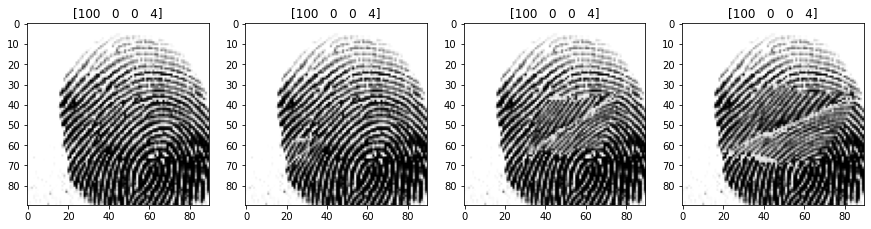

In [33]:
x_real = np.load('/dataset/x_real.npz')['data']
y_real = np.load('/dataset/y_real.npy')
x_easy = np.load('/dataset/x_easy.npz')['data']
y_easy = np.load('/dataset/y_easy.npy')
x_medium = np.load('/dataset/x_medium.npz')['data']
y_medium = np.load('/dataset/y_medium.npy')
x_hard = np.load('/dataset/x_hard.npz')['data']
y_hard = np.load('/dataset/y_hard.npy')
#손가락 지문 데이터 세트
#
print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10)) # 그래프의 크기
plt.subplot(1, 4, 1) # 그래프를 여러개를 표현 plt.subplot(row,column,index)
plt.title(y_real[1])
plt.imshow(x_real[1].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[5])
plt.imshow(x_easy[5].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[5])
plt.imshow(x_medium[5].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[5])
plt.imshow(x_hard[5].squeeze(), cmap='gray')

# 훈련세트 테스트세트 분할

In [34]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0) # easy medium hard 데이터 합치기
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)
# x_train, x_val, label_train, label_val 훈련세트 테스트 세트로 분할
print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

(49270, 90, 90, 1) (49270, 4)
(44343, 90, 90, 1) (44343, 4)
(4927, 90, 90, 1) (4927, 4)


#  lookup 테이블

In [43]:
label_real_dict = {} # 라벨 데이터로 이미지를 바로 찾을수있는 테이블

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i # ex) '[100 1 0 2] → 1' 알기 쉽게 인덱스로

# Data Generator

In [41]:
class DataGenerator(keras.utils.Sequence): # 이미지를 학습 시킬때 학습데이터의 양이 적을 경우 학습데이터를 늘리는 방식
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
      # 배치사이즈=32, 셔플=사용
      'Initialization'
        self.x = x 
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch' # 전체 트레이닝 셋이 신경망을 통과한 횟수
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # 배치 인덱스 생성
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # 학습이미지 숫자 증가
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)), # 이미지를 흐리게 하는 방법 사용
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # 이미지 크기
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # 이미지에서 변경할 영역
                    rotate=(-30, 30), # 변경할 영역을 또 회전
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch) # 흐리게 한 이미지를 x1_batch에 입력
        
        # lookup 테이블로 만든 데이터 사용
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5: # 0.5 이상 = 50퍼확률로
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1. # 라벨이 일치할경우 결과값은 1이다.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0. # 라벨이 불일치 할경우 결과값은 0이다.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [44]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

# 모델 만들기

In [60]:
x1 = layers.Input(shape=(90, 90, 1)) 
x2 = layers.Input(shape=(90, 90, 1))
#x1,x2 입력만들기

# x1,x2 share 하기
inputs = layers.Input(shape=(90, 90, 1)) # 사이즈

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs) # 합성곱
feature = layers.MaxPooling2D(pool_size=2)(feature) # 풀링

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature) # 합성곱
feature = layers.MaxPooling2D(pool_size=2)(feature) # 풀링

feature_model = Model(inputs=inputs, outputs=feature) # 합성곱→풀링→합성곱→풀링 과정을 거쳐 모델 생성

# 만들어진 모델에 x1,x2 집어넣기
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net]) # x1에서 x2를 빼기

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net) # 합성공
net = layers.MaxPooling2D(pool_size=2)(net) # 풀링
# 합성곱 → 풀링 과정 진행
net = layers.Flatten()(net) # 1차원 벡터로 변환

net = layers.Dense(64, activation='relu')(net) # 가중치 64 입력 dense layer

net = layers.Dense(1, activation='sigmoid')(net) # 가중치 1 입력 dense layer 후 sigmoid layer로 0~1사이 값으로 표현

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# binary_crossentropy 이진 분류기를 훈련할 때 자주 사용되는 손실 함수

model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 model_12 (Functional)          (None, 22, 22, 32)   9568        ['input_19[0][0]',               
                                                                  'input_20[0][0]']               
                                                                                                  
 subtract_6 (Subtract)          (None, 22, 22, 32)   0           ['model_12[0][0]',        

# 훈련

In [61]:
history = model.fit_generator(train_gen, epochs=5, validation_data=val_gen) # epochs = 값은 트레이닝횟수 많은수록 정확도가 높아짐

<ipython-input-61-5c41394e0625>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=1, validation_data=val_gen) # epochs = 값은 트레이닝횟수 많은수록 정확도가 높아짐


1385/1385 [==============================] - 850s 613ms/step - loss: 0.2349 - acc: 0.9000 - val_loss: 0.0805 - val_acc: 0.9688


# 평가

1/1 [==============================] - 0s 24ms/step


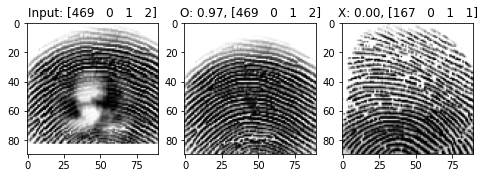

In [65]:
# 새로운 사람 지문 생성
random_idx = random.randint(0, len(x_val))

random_img = x_val[random_idx]
random_label = label_val[random_idx]
# 학습이미지 숫자 증가
seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)), # 이미지를 흐리게 하는 방법 사용
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # 이미지 크기
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # 이미지에서 변경할 영역
        rotate=(-30, 30), # 변경할 영역을 회전
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.
# 랜덤이미지로 입력값 저장
# 1에 가깝게 매칭된 이미지 출력 ( 일치하는 이미지)
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# 0에 가깝게 매칭된 이미지 출력( 일치하지 않는 이미지)
unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
uy = y_real[unmatch_idx]

pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(ux.squeeze(), cmap='gray')